In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import r2_score

from scipy import stats

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

import pyprind

In [2]:
properties = pd.read_csv('data/sales_data_2015.csv', index_col=0, low_memory=False)
sat_data = pd.read_csv('data/sales_data_2015_DF-inception-conv.csv', index_col=0, low_memory=False)
print(properties.shape)

(84768, 26)


In [3]:
# Satelite Dataset
print(sat_data.shape)
print("Unique bbl_ids:", len(sat_data['bbl_id'].unique()))
print("Unique sale_ids:", len(sat_data['Sale_id'].unique()))

(84302, 34)
Unique bbl_ids: 62872
Unique sale_ids: 84302


# Joining

In [4]:
sat_prop = properties.join(sat_data, on='Sale_id', how='inner', lsuffix='_prop', rsuffix='_sat')

In [5]:
#Dropping rows with price, sqft and year = 0
print("Before:", len(sat_prop))
sat_prop = sat_prop[(sat_prop.yr_built != 0) & (sat_prop.tot_sqft != 0) & (sat_prop.price != 0)]
print("After:", len(sat_prop))

Before: 84301
After: 28401


# Preprocessing

In [6]:
sat_prop.shape

(28401, 61)

In [7]:
#Dropping rows with price less than 10k, indiciates some family transfers and not everly useful in general
print("Before", len(sat_prop[(sat_prop['price'] < 10000)]))
sat_prop = sat_prop[sat_prop.price > 10000]
print("After", len(sat_prop[(sat_prop['price'] < 10000)]))

print("Minimum price:", sat_prop['price'].min())
print("Maximum price:", sat_prop['price'].max())

Before 813
After 0
Minimum price: 10667
Maximum price: 555000000


In [8]:
sat_prop.isna().sum().sort_values(ascending=False)

easmnt         27559
apt            27123
31                 0
com_unit           0
Sale_id_sat        0
               ...  
6                  0
5                  0
4                  0
3                  0
Sale_id            0
Length: 61, dtype: int64

In [9]:
#Dropping nan columns
sat_prop = sat_prop.drop(['easmnt', 'apt'], axis=1)

In [10]:
#Dropping id columns, year, zip, lon lat coordinates, lot id
sat_prop = sat_prop.drop(['usable','sale_date', 'address', 'bbl_id_prop', 
                      'Sale_id', 'year', 'lot', 'Sale_id_prop', 'res_unit', 'com_unit',
                      'bbl_id_sat', 'bbl_id_sat', 'Sale_id_sat', 'lat', 'long'], axis=1)

In [11]:
# sat_prop.info()

## Hot encoding

In [12]:
X_enc = sat_prop.copy()
X_enc = pd.get_dummies(X_enc, columns=['bldg_ctgy','tax_cls_s','tax_cls_p','bldg_cls_p', 'bldg_cls_s'])
sat_prop = X_enc

print(sat_prop.shape)

(27559, 351)


## Outlier detection for prices

In [13]:
z_score_price = np.abs(stats.zscore(sat_prop['price']))
sat_prop['z_score_price'] = z_score_price

z_score_tot_sqft = np.abs(stats.zscore(sat_prop['tot_sqft']))
sat_prop['z_score_tot_sqft'] = z_score_tot_sqft

# z_score_yr_built = np.abs(stats.zscore(sat_prop['yr_built']))
# sat_prop['z_score_yr_built'] = z_score_yr_built

print("Before shape:", sat_prop.shape)

sat_prop = sat_prop[(sat_prop.z_score_price < 3) & (sat_prop.z_score_tot_sqft < 3)]
sat_prop = sat_prop.drop(['z_score_tot_sqft', 'z_score_price'], axis=1)

print("After shape:", sat_prop.shape)

Before shape: (27559, 353)
After shape: (27339, 351)


# EDA

In [14]:
sat_prop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27339 entries, 4 to 84297
Columns: 351 entries, borough to bldg_cls_s_Z9
dtypes: float64(32), int64(8), uint8(311)
memory usage: 16.7 MB


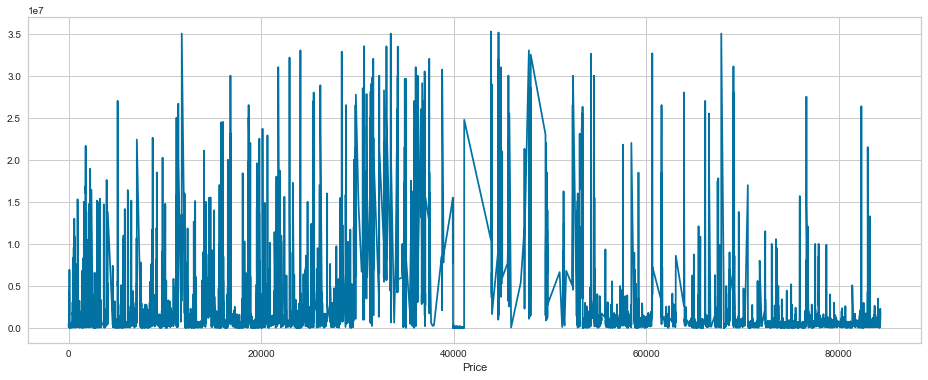

In [15]:
# Prices dist
prices = sat_prop['price']
plt.figure(figsize=(16,6))
plt.xlabel("Price")
plt.plot(prices)

Text(0.5, 1.0, 'Prices vs Total sqft')

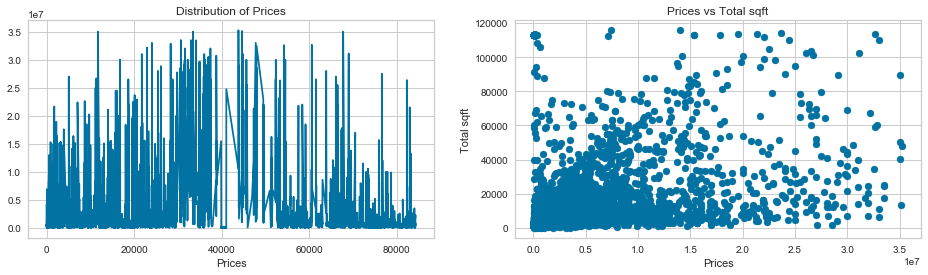

In [16]:
f, ax = plt.subplots(1, 2)
f.set_figwidth(16,2)
ax[0].plot(sat_prop['price'])
ax[0].set_xlabel("Prices")
ax[0].set_title("Distribution of Prices")

ax[1].scatter(sat_prop['price'], sat_prop['tot_sqft'])
ax[1].set_xlabel("Prices")
ax[1].set_ylabel("Total sqft")
ax[1].set_title("Prices vs Total sqft")

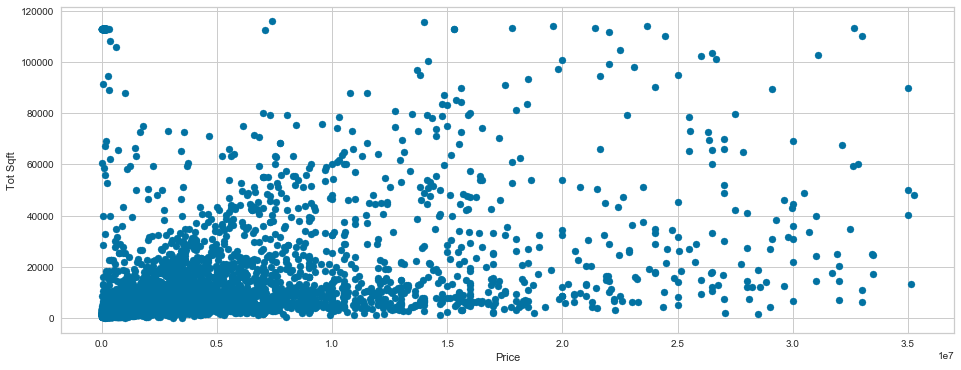

In [17]:
plt.figure(figsize=(16,6))
plt.xlabel("Price")
plt.ylabel("Tot Sqft")
plt.scatter(sat_prop['price'], sat_prop['tot_sqft'])

## Export proccessed data

In [18]:
# sat_prop.to_csv("out/processed_data.csv")

# Analysis

In [19]:
property_prices = sat_prop['price']
print(property_prices.shape)

(27339,)


In [20]:
property_data = sat_prop.drop(['price'], axis=1)
print(property_data.shape)

(27339, 350)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(property_data, property_prices, test_size=0.1, random_state=42)

## Linear Reg.

In [22]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# R^2 scores
print('Train:', lr.score(X_train, y_train))
print('Test:', lr.score(X_test, y_test))

print("MAE:",mean_absolute_error(y_test, y_pred))
print("MSE:",mean_squared_error(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

Train: 0.5360790334712586
Test: 0.5004195120838903
MAE: 793797.3735698145
MSE: 3680995887660.4214
RMSE: 1918592.162931044


In [23]:
scores = cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=10, n_jobs=-1, scoring='r2')
print("Scores", scores)
print("Mean Score:", np.mean(scores))

Scores [0.50394395 0.48306226 0.5126812  0.51784593 0.44610235 0.43697514
 0.41484593 0.43818762 0.50561801 0.47728367]
Mean Score: 0.47365460609539445


## Lasso Regression

In [24]:
lasso = Lasso(alpha=20)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

print("r2 Test score:",r2_score(y_test, y_pred))
print("MAE:",mean_absolute_error(y_test, y_pred))
print("MSE:",mean_squared_error(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

r2 Test score: 0.4997127211600676
MAE: 791058.4002213563
MSE: 3686203646063.636
RMSE: 1919948.8654814838


/Users/hrvojegrgic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.59308730441676e+16, tolerance: 19717638861024.52
  positive)


In [25]:
scores = cross_val_score(estimator=Lasso(alpha=20), X=X_train, y=y_train, cv=10, n_jobs=-1, scoring='r2')
print("Scores", scores)
print("Mean Score:", np.mean(scores))

Scores [0.50633902 0.46567312 0.50143397 0.53910121 0.44862662 0.44113667
 0.41494517 0.44086648 0.51426081 0.49000842]
Mean Score: 0.4762391481611098


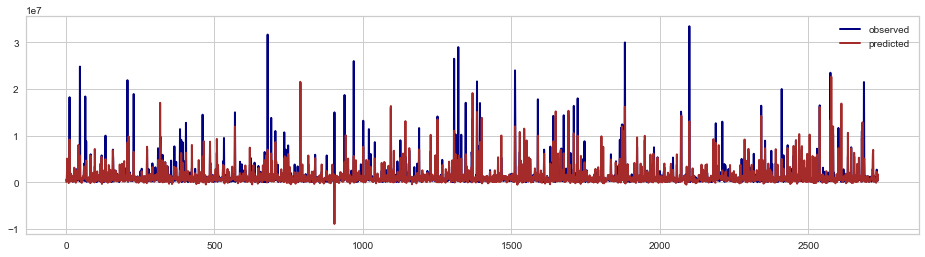

In [26]:
lasso_obs_pred=pd.DataFrame({'entry': range(1,len(y_test)+1), 'observed': y_test, 'predicted': y_pred})
plt.figure(figsize=(16,4))
plt.plot('entry', 'observed', data=lasso_obs_pred, marker='', color='navy', linewidth=2)
plt.plot('entry', 'predicted', data=lasso_obs_pred, marker='', color='brown', linewidth=2)
plt.legend()

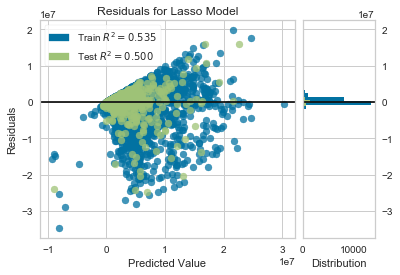

In [27]:
visualizer = ResidualsPlot(lasso, hist=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Gradient Boost

In [28]:
gb_2 = GradientBoostingRegressor(n_estimators=200,max_depth=12, verbose=True)
gb_2.fit(X_train, y_train)
gb_2_predicted = gb_2.predict(X_test)

print('Score on training', gb_2.score(X_train, y_train))
print("Score on test:", r2_score(y_test, gb_2_predicted))

      Iter       Train Loss   Remaining Time 
         1 6629964902506.1416            6.76m
         2 5499380393473.2373            6.84m
         3 4568766633417.4453            6.68m
         4 3820145028620.0210            6.64m
         5 3181746911089.2666            6.69m
         6 2660632229485.2227            6.73m
         7 2233149742407.1157            6.69m
         8 1878775421929.0874            6.69m
         9 1588556347090.1858            6.67m
        10 1343036513552.4731            6.62m
        20 324659712207.1556            6.21m
        30 133271433774.2733            5.84m
        40 85566694448.7026            5.28m
        50 65400665161.4947            4.88m
        60 56280676993.7409            4.39m
        70 50170122348.1039            3.97m
        80 47445933353.2764            3.48m
        90 44531234953.6675            3.06m
       100 42280844184.5001            2.67m
       200 27713168478.5660            0.00s
Score on training 0.996541763873

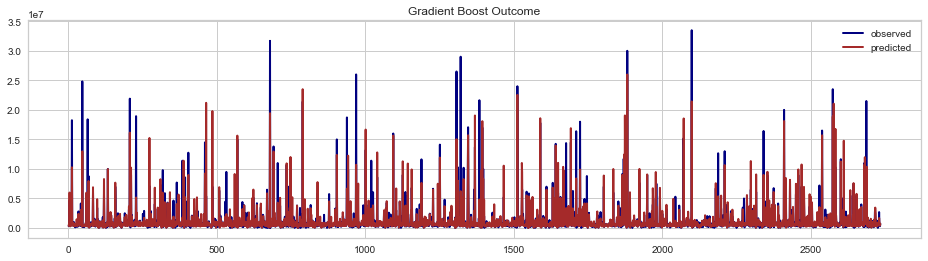

In [29]:
gb_obs_pred=pd.DataFrame({'entry': range(1,len(y_test)+1), 'observed': y_test, 'predicted': gb_2_predicted})
plt.figure(figsize=(16,4))
plt.title("Gradient Boost Outcome")
plt.plot('entry', 'observed', data=gb_obs_pred, marker='', color='navy', linewidth=2)
plt.plot('entry', 'predicted', data=gb_obs_pred, marker='', color='brown', linewidth=2)
plt.legend()

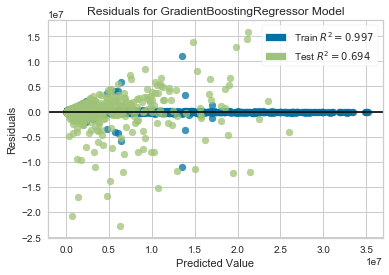

In [30]:
visualizer = ResidualsPlot(gb_2, hist=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

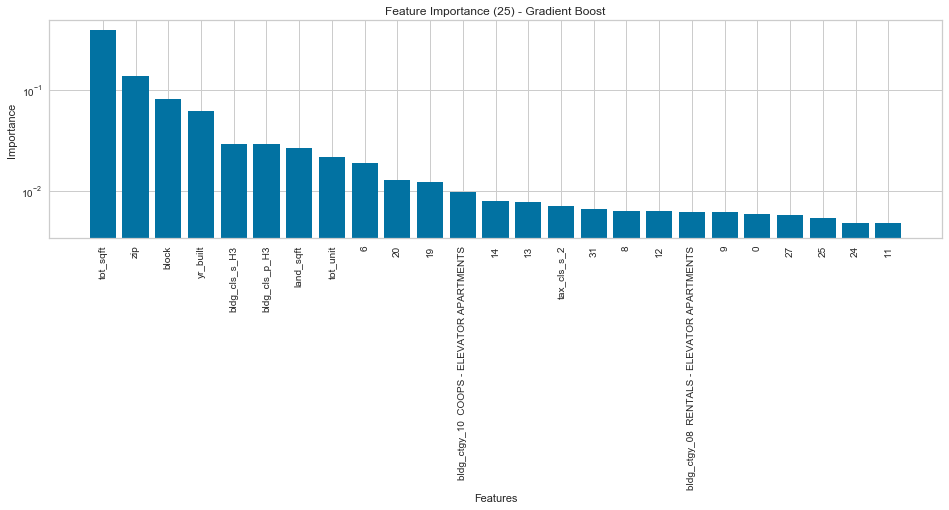

In [31]:
treshold = 25

df_feature_importance = pd.DataFrame()
df_feature_importance['features'] = list(property_data)
df_feature_importance['importance'] = gb_2.feature_importances_

df_feature_importance = df_feature_importance.sort_values('importance').tail(treshold)

plt.figure(figsize=(16,4))
plt.yscale('log',nonposy='clip')
plt.bar(range(treshold),df_feature_importance['importance'][:treshold].values[::-1],align='center')

plt.xticks(range(treshold),df_feature_importance['features'][:treshold].values[::-1],rotation='vertical')
plt.title('Feature Importance (25) - Gradient Boost')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

## Tree Regressors

In [32]:
rf_2 = RandomForestRegressor(n_estimators=200,criterion='mse',max_depth=20,random_state=42, verbose=True)
rf_2.fit(X_train, y_train)
rf_2_predicted = rf_2.predict(X_test)

print("R2 Train score:", rf_2.score(X_train, y_train))
print("R2 Test score:", r2_score(y_test, rf_2_predicted))
print("MAE:",mean_absolute_error(y_test, rf_2_predicted))
print("MSE:",mean_squared_error(y_test, rf_2_predicted))
print("RMSE:",np.sqrt(mean_squared_error(y_test, rf_2_predicted)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


R2 Train score: 0.9528051711571689
R2 Test score: 0.7306980143876152
MAE: 441362.5139625239
MSE: 1984263848480.078
RMSE: 1408639.0057357058


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished


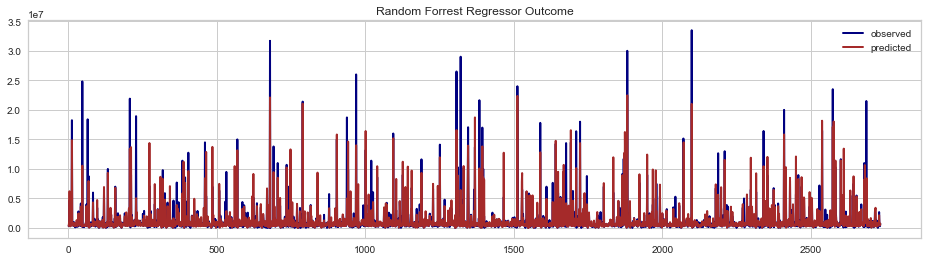

In [33]:
rf_obs_pred=pd.DataFrame({'entry': range(1,len(y_test)+1), 'observed': y_test, 'predicted': rf_2_predicted})
plt.figure(figsize=(16,4))
plt.title("Random Forrest Regressor Outcome")
plt.plot('entry', 'observed', data=rf_obs_pred, marker='', color='navy', linewidth=2)
plt.plot('entry', 'predicted', data=rf_obs_pred, marker='', color='brown', linewidth=2)
plt.legend()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


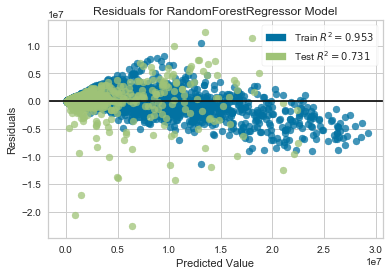

In [34]:
visualizer = ResidualsPlot(rf_2, hist=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

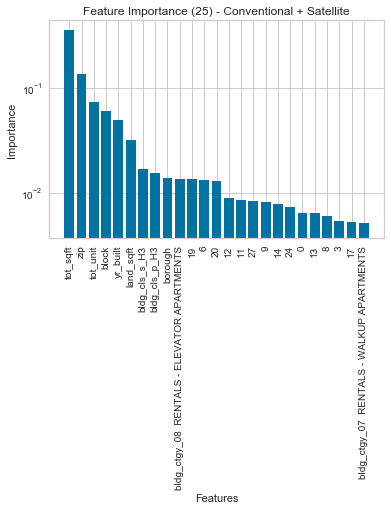

In [36]:
treshold = 25

df_feature_importance = pd.DataFrame()
df_feature_importance['features'] = list(property_data)
df_feature_importance['importance'] = rf_2.feature_importances_

df_feature_importance = df_feature_importance.sort_values('importance').tail(treshold)

plt.figure(figsize=(6,4))
plt.yscale('log',nonposy='clip')
plt.bar(range(treshold),df_feature_importance['importance'][:treshold].values[::-1],align='center')

plt.xticks(range(treshold),df_feature_importance['features'][:treshold].values[::-1],rotation='vertical')
plt.title('Feature Importance (25) - Conventional + Satellite')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()